<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Do-the-binning" data-toc-modified-id="Do-the-binning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do the binning</a></span></li><li><span><a href="#LST-bin-the-Autos" data-toc-modified-id="LST-bin-the-Autos-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LST-bin the Autos</a></span><ul class="toc-item"><li><span><a href="#In-painted-Mode" data-toc-modified-id="In-painted-Mode-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>In-painted Mode</a></span></li><li><span><a href="#Flagged-Mode" data-toc-modified-id="Flagged-Mode-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Flagged-Mode</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Cross-Pairs" data-toc-modified-id="Cross-Pairs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cross-Pairs</a></span></li></ul></div>

# LST-Bin

**by Steven Murray**, last updated 27th Mar, 2024.

This notebook performs LST-binning, producing a **single output file**. The input to this notebook consists of two configuration files, and one index:

1. A `fileconf`, which is *produced* by `hera_cal.lstbin_simple.make_lst_bin_config_file()` run over a set of raw files. This file lists all the raw files that correspond to all the particular bins, which makes it quick for this notebook to read them in.
2. A binning configuration file, `config`, that specifies all the parameters to use when performing the binning itself.
3. The file index that corresponds to the LST bins that will be saved to the output file in _this_ notebook.

The notebook then proceeds to do essentially the same thing as `hera_cal.lstbin_simple.lst_bin_files_single_outfile`, but with extra plotting and inspection stops along the way.

## Imports

In [1]:
import os
import sys
from pathlib import Path
from functools import partial
from datetime import datetime
from time import time as _time
import resource
from collections import UserDict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import attrs

from scipy import linalg
from hera_filters import dspec

from pyuvdata import UVData
from hera_cal import lst_stack as lstbin
from hera_cal.lst_stack.config import LSTConfig
from hera_cal.red_groups import RedundantGroups
from hera_cal.lst_stack import metrics as lstmet
from hera_cal.lst_stack import stats as lststat
from hera_cal import vis_clean, redcal, abscal, utils
import importlib

In [2]:
start_time = _time()

## Configuration

In [3]:
fileconf: str = "/lustre/aoc/projects/hera/h6c-analysis/IDR2/lstbin-outputs/redavg-smoothcal-notebook/file-config.h5"
fileidx: int = 380

papermill_input_path: str = ""
papermill_output_path: str = ""

# The following are defaults that can be overwritten at execution time (preferably by a YAML file)
save_lstbin_data: bool = True
save_metric_data: bool = True
plot_n_worst: int = 5
do_simultaneous_inpainting: bool = True
do_extra_flagging: bool = True
do_lstcal: bool = True

outdir: str = "."
bl_chunk_size: int = 0
rephase: bool = True
vis_units: str = "Jy"
fname_format: str = '{inpaint_mode}/zen.{kind}.{lst:7.5f}.sum.uvh5'
overwrite: bool = True
write_med_mad: bool = False
do_inpainted_average: bool = False
freq_min: float = 0.0
freq_max: float = 0.0
history: str = ""
plot_every: int = 1

# In-painting config
delay_filter_horizon: float     = 1.0
delay_filter_standoff: float    = 0.0    # ns
delay_filter_mindelay: float    = 150.0  # ns
delay_filter_eigencutoff: float = 1e-12
# inpaint_regularization: float   = 1e-5   # reasonable values are between 1e-2 and 1e-5
inpaint_mindelay: float         = 500.0  # ns
inpaint_cache_dir: str         = ""  # leave empty to NOT write cache to file. If a file, all LST-bins should use the same file so they can take advantage of it.

# Flagging Configuration
zscore_threshold: float = 5              # Value of |Z| above which data are flagged. 
iterative_flagging_factor: float = 1.5   # When flagging on |Z|^2, the worst offender (W) is flagged, and any other offenders > W/iterative_flagging_factor
watershed_threshold: float = 3           # Value of |Z| above which data surrounding other flagged data will be flagged.     
max_flagging_iterations: int = 15             # Maximum number of iterations to perform when flagging.

In [4]:
# TODO: using the filter cache doesn't work yet, because the keys are tuples, not strings
class FilterCache(UserDict):
    def __init__(self, cachedir: str | Path | None = None, *args, **kwargs):
        if cachedir:
            self._cachedir = Path(cachedir)
        else:
            self._cachedir = None
        
        super().__init__(*args,**kwargs)
        
    def __getitem__(self, item):
        try:
            return super().__getitem__(item)
        except KeyError as e:
            if self._cachedir is None:
                raise
            
            possible_keys = [pth.name for pth in self._cachedir.glob("*")]
            
            if item in possible_keys:
                with (self._cachedir / item).open('rb') as fl:
                    out = pickle.load(fl)
                self[item] = out
                return out
            
            raise
                 
    def __setitem__(self, item, value):
        if self._cachedir is not None:
            with (self._cachedir / item).open('wb') as fl:
                pickle.dump(fl, value)
            
        super().__setitem__(item, value)
    

In [5]:
# Parameter changes for typing
outdir = Path(outdir)
if freq_max <= 0.0:
    freq_max = None
if freq_min <= 0.0:
    freq_min = None
if bl_chunk_size <= 0:
    bl_chunk_size = None

In [6]:
make_plots = (fileidx % plot_every) == 0

In [7]:
if make_plots or save_metric_data:
    get_metrics = True
else:
    get_metrics = False

In [8]:
fileconf = Path(fileconf)
assert fileconf.exists() and fileconf.is_file(), "The input file-configuration file is not a file"

In [9]:
stackconf = LSTConfig.from_file(fileconf)

In [10]:
print("The LST grid was configured with these parameters: \n")
for key, val in attrs.asdict(stackconf.config).items():
    if key != 'data_files':
        print(f"  {key:>36}: {val}")

The LST grid was configured with these parameters: 

                        nlsts_per_file: 2
                                  dlst: 0.0007047089846545072
                                  atol: 1e-10
                             lst_start: 0.0
                               lst_end: 6.283185307179586
                              jd_regex: zen\.(\d+\.\d+)\.
                         calfile_rules: None
            where_inpainted_file_rules: [('.sum.*.uvh5', '.where_inpainted.h5')]
                           ignore_ants: ()
    antpairs_from_last_file_each_night: True


In [11]:
print("The raw files have the following properties: \n")
for key, val in stackconf.properties.items():
    print(f"  {key:>25}: {val}")

The raw files have the following properties: 

       blts_are_rectangular: True
                   first_jd: 2459861.2529114624
             lst_branch_cut: 5.406879684761707
  time_axis_faster_than_bls: True
              x_orientation: north


In [12]:
stackconf = stackconf.at_single_outfile(fileidx)

In [13]:
print(f"LST bin edges considered in this notebook (file index {fileidx}):")
print(f"  {stackconf.lst_grid_edges}")

LST bin edges considered in this notebook (file index 380):
  [0.53557883 0.53628354 0.53698825]


In [14]:
print(f"Raw files used in this notebook (for all bins): \n")
for fl in stackconf.matched_files:
    print(fl.name)

Raw files used in this notebook (for all bins): 

zen.2459861.47689.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459861.47711.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459862.47432.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459863.47141.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459863.47163.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459864.46867.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459864.46889.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459866.46342.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459867.46069.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459868.45795.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459869.45521.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459870.45247.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459871.44973.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459872.44691.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459872.44714.sum.smooth_calibrated.red_avg.inpaint.uvh5
zen.2459873.44425.sum.smooth_calibr

In [15]:
print(f"The data has {len(stackconf.autopairs + stackconf.antpairs)} ant-pairs, and {stackconf.pols} polarizations.")

The data has 880 ant-pairs, and ['ee', 'nn'] polarizations.


In [16]:
outdir = Path(outdir)
if not outdir.exists():
    outdir.mkdir(parents=True, exist_ok=True)

In [17]:
print(f"Writing output files to: \n  {outdir}")

Writing output files to: 
  .


In [18]:
if do_simultaneous_inpainting and do_inpainted_average:
    raise ValueError("Cannot do both simultaneous inpainting and per-day inpainted averaging")
    
if do_inpainted_average and stackconf.inpaint_files is None:
    raise ValueError("Cannot do per-night inpainted average without inpainted files")

In [19]:
# Split up the baselines into chunks that will be LST-binned together.
# This is just to save on RAM.
if bl_chunk_size is None:
    bl_chunk_size = len(stackconf.antpairs)
else:
    bl_chunk_size = min(bl_chunk_size, len(stackconf.antpairs))

n_bl_chunks = int(np.ceil(len(stackconf.antpairs) / bl_chunk_size))

In [20]:
out_fname = lstbin.format_outfile_name(
    fname_format=fname_format, lst=stackconf.lst_grid_edges[0], inpaint_mode=True,
    pols=stackconf.pols, lst_branch_cut=stackconf.properties["lst_branch_cut"],
)

In [21]:
_INPAINT_CACHE_ = FilterCache(inpaint_cache_dir)

In [22]:
reds_with_pols = RedundantGroups.from_antpos(antpos={i: pos for i, pos in enumerate(stackconf.config.datameta.antpos_enu)}, pols=stackconf.pols)

In [23]:
def print_metadata():
    # A function that prints metadata about the notebook
    print("Software Versions Used: ")
    for repo in ['numpy', 'scipy', 'astropy', 'hera_cal', 'hera_qm', 'hera_filters', 'hera_notebook_templates', 'pyuvdata']:
        mdl = importlib.import_module(repo)
        print(f'{repo:>25}: {mdl.__version__}')
        
    print("Run by: ", end='')
    os.system("whoami");

    print(f"Run on {datetime.now()}")
    print(f"Execution of notebook took: {(_time() - start_time)/60.0:.2f} minutes")
    print(f"Peak memory in this notebook run: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024**2:.2f} GB")

In [24]:
if len(set(sum((x.tolist() for x in stackconf.time_indices), start=[]))) != stackconf.n_lsts:
    print("LST-Stacking for files where not all of the LST-bins have associated data is not yet supported.")
    print_metadata()
    sys.exit(0)

In [25]:
# If this notebook is making plots, and is being run through PAPERMILL, output an empty
# file that tells the execution script to save a copy of the output notebook to the
# public-facing notebook directory.
if papermill_output_path and make_plots:
    pth = Path(f"{papermill_output_path}.hasplots")
    pth.touch()

## Define Stacking/Averaging Functions

Define and initialize the output files that we will write in this notebook:

Now, define a function that uses the configuration we've established and performs LST-binning for a subset of baselines.

In [26]:
def stack_blchunk(bl_chunk: int | str):
    """Process a single chunk of baselines."""
    stacks: list[UVData] = lstbin.binning.lst_bin_files_from_config(
        stackconf,
        bl_chunk_to_load=bl_chunk,
        nbl_chunks=n_bl_chunks,
    )

    rdcs = []
    for lstidx, stack in enumerate(stacks):

        rdc = lstbin.averaging.reduce_lst_bins(
            lststack=stack,
            inpainted_mode=False,
            get_mad=write_med_mad and not (do_inpainted_average or do_simultaneous_inpainting),  # MED/MAD gotten later if doing inpainting
        )
        rdcs.append(rdc)
                     
    return stacks, rdcs

## Plotting Style Setup

In [27]:
data_jd_ints = sorted({int(meta.times[0]) for meta in stackconf.matched_metas})

In [28]:
styles = {}

for i, jdint in enumerate(data_jd_ints):
    styles[jdint] = {'color': f"C{i%10}", 'ls': ['-', '--', ':', '-.'][i//10]}

## Define Subsets of Data to Consider

### Bands

In [29]:
bands_considered = [
    (0, 200), (200, 400), (400, 600), (600, 800), (800, 1000), (1000, 1200), (1200, 1400), (1400, 1536),
    (0, 450),    # low band
    (450, 1536), # high band
    (0, 1536),   # full band
]

### Baselines

In [30]:
def get_all_antenna_sectors():
    antpos = stackconf.config.datameta.antenna_positions
    zero_pos = np.mean([antpos[165], antpos[166], antpos[145]], axis=0)
    
    sectors = {}
    for ant, pos in enumerate(antpos):
        rec = pos - zero_pos
        theta = np.arctan2(rec[1], rec[0])
        bllen = np.sqrt(rec[0]**2 + rec[1]**2)
        if bllen > 200:
            sectors[ant] = 4  # outrigger
        elif -np.pi / 3 <= theta < np.pi / 3:
            sectors[ant] = 1
        elif np.pi / 3 <= theta < np.pi:
            sectors[ant] = 2
        elif -np.pi <= theta < -np.pi/3:
            sectors[ant] = 3
    return sectors

sectors = get_all_antenna_sectors()

In [31]:
def getblvec(a, b):
    return auto_stacks[0].antenna_positions[a] - auto_stacks[0].antenna_positions[b]
def getbllen(a,b):
    return np.sqrt(np.sum(np.square(getblvec(a,b))))

In [32]:
all_ee = lambda bl: bl[2] == 'ee'
all_nn = lambda bl: bl[2] == 'nn'
short_bls = lambda bl: getbllen(bl[0], bl[1])<=60.0
long_bls = lambda bl: getbllen(bl[0], bl[1])>60.0
intersector_bls = lambda bl: sectors[bl[0]] != sectors[bl[1]]
intrasector_bls = lambda bl: sectors[bl[0]] == sectors[bl[1]]

subsets = {
    'all': lambda bl: True,
    'ee-only': all_ee,
    'nn-only': all_nn,
    'Short (<60 m) baselines': short_bls,
    'Long (>60 m) baselines': long_bls,
    'Inter-sector baselines': intersector_bls,
    "Intra-sector baselines": intrasector_bls,
}

## LST-bin the Autos

In [33]:
def make_auto_plot(auto_stacks: list[UVData], lstbin: list[dict]):
    
    fig, ax = plt.subplots(
        len(stackconf.autopairs)*len(stackconf.pols), len(auto_stacks), 
        sharex=True, sharey=True, squeeze=False, constrained_layout=True,
        figsize=(12, 6)
    )

    for i, (stack, avg) in enumerate(zip(auto_stacks, lstbin)):
        for j, autopair in enumerate(stackconf.autopairs):
            for p, pol in enumerate(stackconf.pols):
                axx = ax[j*len(stackconf.pols) + p, i]
                
                for k, t in enumerate(stack.time_array[::stack.Nbls]):
                    flg = stack.get_flags(autopair + (pol,))[k]
                    d = stack.get_data(autopair+(pol,))[k]
                    
                    axx.plot(
                        stack.freq_array / 1e6,
                        np.where(flg, np.nan, d.real),
                        label=f"{int(t)}" if not p else None,
                        **styles[int(t)]
                    )
                    axx.set_yscale('log')
                    axx.set_title(f"Pair {autopair}, pol={pol}, LST {stackconf.lst_grid[i]*12/np.pi:.3f} hr")

                # plot the mean
                axx.plot(
                    stack.freq_array / 1e6,
                    np.where(avg['flags'][j, :, p], np.nan, avg['data'][j, :, p].real),
                    label='LSTBIN',
                    color='k', lw=2
                )
                
    ax[0,0].legend(ncols=3)

In [34]:
auto_stacks, autos_lstavg = stack_blchunk('autos') # Auto-stacks
cross_stacks, cross_lstavg = stack_blchunk(0) # Cross-stacks

### LST-Bin Calibration

In [35]:
def complex_phase_abscal(data, model, reds, data_bls, model_bls, transformed_antpos=None):
    """
    Modified version of the complex_phase_abscal function which allows user to pass if transformed_antpos
    if already computed
    """
    # Check that baselines selected are for the same polarization
    pols = list(set([bl[2] for bls in (data_bls, model_bls) for bl in bls]))
    assert len(pols) == 1, 'complex_phase_abscal() can only solve for one polarization at a time.'

    # Get transformed antenna positions and baselines
    if not transformed_antpos:
        transformed_antpos = redcal.reds_to_antpos(reds)
        abscal._put_transformed_array_on_integer_grid(transformed_antpos)
        
    transformed_b_vecs = np.rint(
        [transformed_antpos[jj] - transformed_antpos[ii] for (ii, jj, pol) in data_bls]
    ).astype(int)

    # Get number of baselines and times/freqs
    Ngroups = len(data_bls)
    Ntimes, Nfreqs = data[data_bls[0]].shape

    # Build up array of Fourier coefficients of the objective function
    Z_coefficients = np.zeros((Ntimes, Nfreqs, Ngroups), dtype=complex)
    for nn in range(Ngroups):

        Vhat_n = data[data_bls[nn]]
        Vbar_n = model[model_bls[nn]]

        Z_coefficients[:, :, nn] = Vhat_n * np.conj(Vbar_n)

    # Get solution for degenerate phase gradient vectors
    Lambda_sol, Z_sol, newton_iterations = abscal._phase_gradient_solution(Z_coefficients, transformed_b_vecs)

    # turn solution into per-antenna gains
    phase_angle = {a: np.sum(Lambda_sol * r, axis=-1) for a, r in transformed_antpos.items()}
    delta_gains = {(a, utils.split_pol(pols[0])[0]): np.exp(1j * (angle)) for a, angle in phase_angle.items()}
    meta = {'Lambda_sol': Lambda_sol, 'Z_sol': Z_sol, 'newton_iterations': newton_iterations, "transformed_antpos": transformed_antpos}
    return meta, delta_gains


def lstbin_calibration(
    stack,
    model, 
    all_reds,
    inpaint_bands,
    run_amplitude_cal: bool=True, 
    run_phase_cal: bool=True, 
    smoothing_scale: float=10e6,
    calibrate_inplace: bool=True,
    return_gains: bool=True
):
    """
    
    Parameters:
    ----------
        stack : LSTStack
        model : dictionary
        inpaint_bands : tuple
        run_amplitude_cal : bool
        run_phase_cal : bool
        smoothing_scale : float
    
    """
    # Assert some calibration done
    assert run_amplitude_cal or run_phase_cal, "At least one calibration mode must be used"
    assert stack.data.shape[1:] == model.shape, "Model must have the same number of antpairs/freqs/pols as stack.data"
    
    # Get variables used for both functions 
    antpairs = stack.antpairs[:]
    pols = stack.pols
    
    # Function for storing calibration parameters
    calibration_parameters = {}
    
    # Get DPSS for each band
    smoothing_functions = []
    for band in inpaint_bands:
        smoothing_functions.append(
            dspec.dpss_operator(
                x=stack.freq_array[band], 
                filter_centers=[0], 
                filter_half_widths=[1 / smoothing_scale], 
                eigenval_cutoff=[delay_filter_eigencutoff]
            )[0]
        )
        
    # Dictionaries for storing data used in abscal functions
    data_here = {}
    wgts_here = {}
    abscal_model = {}
    amp_start = _time()
    # Loop through baselines and polarizations
    for polidx, pol in enumerate(pols):
        for apidx, (ant1, ant2) in enumerate(antpairs):

            blpol = (ant1, ant2, pol)
            
            # Move to the next blpol if there is not a model for the data or the entire baseline is flagged
            if np.all(stack.flags[:, apidx, :, polidx]):
                continue
        
            # Get model, weights, and data for each baseline 
            abscal_model[blpol] = model[apidx, :, polidx] * np.ones((len(stack.nights), 1))
            data_here[blpol] = stack.data[:, apidx, :, polidx]
            wgts_here[blpol] = stack.nsamples[:, apidx, :, polidx] * (~stack.flags[:, apidx, :, polidx]).astype(float)
    
    # Perform amplitude calibration
    if run_amplitude_cal:            
        # Store gain solutions in paramter dictionary
        solution = abscal.abs_amp_lincal(
            model=abscal_model, 
            data=data_here, 
            wgts=wgts_here, 
            verbose=False
        )
        
        
        
        for pol in pols:
            # Calibration parameters store in an N_nights by N_freqs array
            amplitude_gain = np.where(np.isfinite(solution[f"A_J{pol}"]), solution[f"A_J{pol}"], 1.0 + 0.0j)
            amplitude_gain = np.where(np.isclose(amplitude_gain, 0.0), 1.0 + 0.0j, amplitude_gain)
            calibration_parameters[f"A_J{pol}"] = amplitude_gain    
    else:
        # Fill in amplitude w/ ones if no running amplitude calibration 
        for pol in pols:
            calibration_parameters[f"A_J{pol}"] = np.ones((len(stack.nights), stacks.freq_array.size), dtype=complex)
                        
    phase_gains = {}
    if run_phase_cal:
        gain_ants = set()
        for ap in antpairs:
            gain_ants.update(ap)
        gain_ants = list(gain_ants)
        
        transformed_antpos = None
        
        # Gains for phase
        phase_gains = {(ant, "J" + pol): [] for ant in gain_ants for pol in pols}
        
        for nightidx, night in enumerate(stack.nights):
            
            # Store phase calibration parameters
            phase_calibration_parameters = {(ant, pol): [] for ant in gain_ants for pol in pols}
            
            for polidx, pol in enumerate(pols):
                cal_bls = []
                
                _data_here = {}
                _abscal_model = {}
                
                if np.all(stack.flags[nightidx, :, :, polidx]):
                    # Store 
                    for ant in gain_ants:
                        phase_gains[(ant, f"J{pol}")].append(
                            np.ones(stack.freq_array.shape, dtype=complex)
                        )
                    continue
                
                for apidx, (ant1, ant2) in enumerate(antpairs):
                    blpol = (ant1, ant2, pol)
                    
                    if np.all(stack.flags[nightidx, apidx, :, polidx]):
                        continue

                    cal_bls.append((ant1, ant2, pol))
                    _data_here[blpol] = stack.data[nightidx, apidx, :, polidx][np.newaxis]
                    _abscal_model[blpol] = model[apidx, :, polidx][np.newaxis]
                    
                
                metadata, delta_gains = complex_phase_abscal(
                    data=_data_here, 
                    model=_abscal_model, 
                    reds=all_reds, 
                    model_bls=cal_bls, 
                    data_bls=cal_bls,
                    transformed_antpos=transformed_antpos
                )
                
                transformed_antpos = metadata['transformed_antpos']
            
                # Store 
                for ant in gain_ants:
                    _gain_here = delta_gains.get((ant, f"J{pol}"), np.ones((1, stack.freq_array.shape[0]), dtype=complex))[0]
                    phase_gains[(ant, f"J{pol}")].append(
                        np.where(np.isfinite(_gain_here), _gain_here, 1.0 + 0.0j)
                    )
                    
        for key in phase_gains:
            phase_gains[key] = np.array(phase_gains[key])
            
            
    # Pre-compute matrices for smoothing fits
    fmats = {pol: [] for pol in pols}
    for polidx, pol in enumerate(pols):
        for bandidx, band in enumerate(inpaint_bands):
            # Get weights and basis functions for the fit
            wgts = np.logical_not(stack.flags[:, 0, band, polidx]).astype(float)
            basis = smoothing_functions[bandidx]
            
            # Compute matrices for linear least-squares fits
            xtxinv = np.linalg.pinv([np.dot(basis.T * wi, basis) for wi in wgts])
            xy = basis.T.dot(wgts.T).T
            fmat = np.array([np.dot(_xtxinv, basis.T) * _w for _xtxinv, _w in zip(xtxinv, wgts)])
            fmats[pol].append(fmat)

    # Dictionary for gain parameters
    gains = {}

    # Iterate for each baseline the array
    for polidx, pol in enumerate(pols):
        for apidx, (ant1, ant2) in enumerate(antpairs):
            bl_gain = np.ones((stack.nights.size, stack.freq_array.size), dtype=complex)
            for bandidx, band in enumerate(inpaint_bands):
                basis = smoothing_functions[bandidx]
                
                # Construct the raw gain and remove nans and infs
                raw_gain = calibration_parameters[f"A_J{pol}"] ** 2 * (
                    phase_gains.get((ant1, "J" + pol), np.ones_like(calibration_parameters[f"A_J{pol}"])) * \
                    phase_gains.get((ant2, "J" + pol), np.ones_like(calibration_parameters[f"A_J{pol}"])).conj()
                )
                raw_gain = np.where(stack.flags[:, 0, band, polidx], 1.0 + 0.0j, raw_gain[:, band])

                # Compute smooth gain for each parameter and remove zeros/nans/infs
                bl_gain_here = np.array(
                   [np.dot(basis, _fmat.dot(_raw_gain)) for _fmat, _raw_gain in zip(fmats[pol][bandidx], raw_gain)]
                )
                bl_gain_here = np.where(np.isfinite(bl_gain_here), bl_gain_here, 1.0 + 0.0j)
                bl_gain_here = np.where(np.isclose(bl_gain_here, 0), 1.0 + 0.0j, bl_gain_here)
                bl_gain[:, band] = bl_gain_here
    
            # Calibrate out smoothed gains
            if calibrate_inplace:
                stack.data[:, apidx, :, polidx] /= bl_gain
            
            # Store gains to return
            if return_gains:
                gains[(ant1, ant2, pol)] = bl_gain
        
    return gains

In [36]:
inpaint_bands = [(0, 87.5), (108.0, 250.0)]  # default below and above FM

# Get slices for the inpaint bands
_inp = []
for _bnd in inpaint_bands:
    idx = np.nonzero((stackconf.config.datameta.freq_array >= _bnd[0] * 1e6) & (stackconf.config.datameta.freq_array < _bnd[1]*1e6))[0]
    _inp.append(slice(idx[0], idx[-1] + 1))
inpaint_bands = _inp
print("Using the following bands for inpainting (channels):")
for bnd in inpaint_bands:
    print(bnd)

Using the following bands for inpainting (channels):
slice(0, 333, None)
slice(501, 1536, None)


In [37]:
if do_lstcal:
    # TODO: Compute prior mean like in LST-cal
    pass

In [38]:
%%time
do_lstcal = False
if do_lstcal:
    for i, (stack, lstavg_model) in enumerate(zip(cross_stacks, cross_lstavg)):
        gains = lstbin_calibration(
            stack=stack, 
            model=lstavg_model['data'], 
            all_reds=reds_with_pols, 
            inpaint_bands=inpaint_bands, 
            calibrate_inplace=True, # calibrate inplace
            run_phase_cal=True, # run phase calibration
            run_amplitude_cal=True, # run amplitude calibration
            return_gains=True # return gains for 
        )
        
    # TODO: Calibrate Autos
        
    # Recompute LST-average for crosses and autos after calibration
    cross_lstavg = [
        lstbin.averaging.reduce_lst_bins(
            lststack=stack,
            inpainted_mode=False,
            get_mad=write_med_mad,
        ) for stack in cross_stacks
    ]
    
    autos_lstavg = [
        lstbin.averaging.reduce_lst_bins(
            lststack=stack,
            inpainted_mode=False,
            get_mad=write_med_mad,
        ) for stack in auto_stacks
    ]

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 28.6 µs


divide by zero encountered in divide


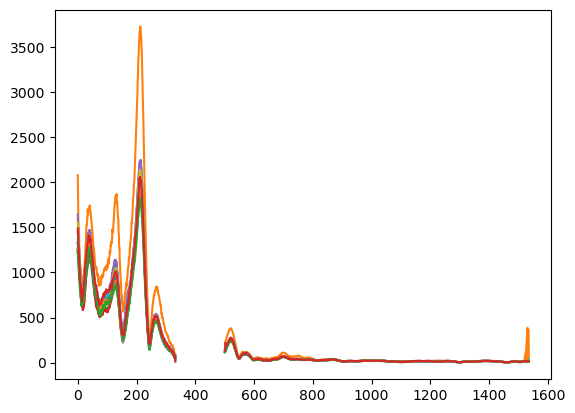

In [39]:
plt.figure()
plt.plot(np.abs(cross_stacks[0].data[:, 0, :, 0].T) / (~cross_stacks[0].flags[:, 0, :, 0].T))
plt.show()

### Compute Stats for Autos

In [ ]:
auto_stats = [
    lstmet.LSTBinStats.from_reduced_data(rdc=rdc, antpairs=stackconf.autopairs, pols=stackconf.pols, reds=reds_with_pols) for rdc in autos_lstavg
]

### Inpaint Autos

In [ ]:
def average_and_inpaint_simultaneously(
    stack, 
    auto_stack, 
    inpaint_bands=(slice(0, None, None),), 
    return_models=True, 
    cache=None, 
    filter_properties=None, 
    alpha=0.0,
    eigenval_cutoff=[1e-12]
):
    """
    """    
    filter_properties = filter_properties or {}
    cache = cache or {}

    # Dictionary for model storage
    all_models = {}

    # Time axis is outer axis for all LSTStacks.
    antpos, ants = stack.get_ENU_antpos(pick_data_ants=False)
    antpos = dict(zip(ants, antpos))

    complete_flags = stack.flagged_or_inpainted()

    # First, perform a simple flagged-mode average over the nights.
    # lstavg is a dict of arrays with keys being 'mean', 'std', 'nsamples', 'flags'.
    lstavg = lstbin.averaging.reduce_lst_bins(
        stack, get_std=False, get_mad=False, inpainted_mode=False, mean_fill_value=0.0
    )

    # Compute noise variance
    assert (auto_stacks[0].data.shape)[1] == 1, 'This code only works with redundantly averaged data, which has only one unique auto per polarization'

    # Arrays for inpainted mean and total samples
    inpainted_mean = np.zeros(stack.Nfreqs, dtype=stack.data.dtype)
    total_nsamples = np.zeros(stack.Nfreqs, dtype=float)
        
    for iap, antpair in enumerate(stack.antpairs, disable=False):
        for polidx, pol in enumerate(stack.pols):
            stackd = stack.data[:, iap, :, polidx] 
            stackf = complete_flags[:, iap, :, polidx]
            stackn = np.abs(stack.nsamples[:, iap, :, polidx])

            # Also get the lst-avg data, flags, and nsamples for this baseline-pol pair.
            flagged_mean = lstavg['data'][iap, :, polidx]
            avg_wgts = lstavg['nsamples'][iap, :, polidx]
            flgs = lstavg['flags'][iap, :, polidx]

            # Compute noise variance for all days in stack
            base_noise_var = np.abs(auto_stack.data[:, 0, :, polidx]) ** 2 / (stack.dt * stack.df).value
            mask = (~stackf).astype(float)
            
            # Shortcut early if there are no flags in the stack. In that case,
            # the LST-average is the same as the flagged-mode mean.
            if (not np.any(stackf)) or np.all(stackf):
                continue

            # Get the baseline vector and length
            bl_vec = (antpos[antpair[1]] - antpos[antpair[0]])[:2]
            bl_len = np.linalg.norm(bl_vec) / lstbin.averaging.constants.c
            filter_centers, filter_half_widths = vis_clean.gen_filter_properties(
                ax='freq',
                bl_len=max(bl_len, 7.0 / lstbin.averaging.constants.c),
                **filter_properties,
            )
            
            # DPSS inpainting model
            model = np.zeros_like(stackd)
            
            # Get median nsamples across the band
            nsamples_by_night = np.median(stackn, axis=1, keepdims=True)
            
            assert np.all(nsamples_by_night == stackn), 'This code assumes that nsamples is constant over frequency for a given night and baseline.'

            for band in inpaint_bands:
                if np.all(stackf[:, band]):
                    continue
                
                # Get basis functions
                basis = dspec.dpss_operator(
                    stack.freq_array[band],
                    filter_centers=filter_centers,
                    filter_half_widths=filter_half_widths,
                    cache=cache,
                    eigenval_cutoff=eigenval_cutoff
                )[0].real

                # compute fits for dpss basis functions
                hash_key = dspec._fourier_filter_hash(
                    filter_centers=filter_centers, 
                    filter_half_widths=filter_half_widths, 
                    x=stack.freq_array[band], 
                    w=base_noise_var
                )
                
                # If key exists in cache, load in filter and invese
                if hash_key in cache:
                    CNinv_1sample_dpss, CNinv_1sample_dpss_inv = cache[hash_key]
                else:
                    CNinv_1sample_dpss = np.array([
                        (basis.T * wgts).dot(basis) + np.eye(basis.shape[1]) * alpha 
                        for wgts in mask[:, band] / base_noise_var[:, band]]
                    )
                    CNinv_1sample_dpss_inv = np.linalg.pinv(CNinv_1sample_dpss)
                    cache[hash_key] = (CNinv_1sample_dpss, CNinv_1sample_dpss_inv)
                    
                    
                # Compute data covariance
                max_allowed_gap_size = COV_INPAINT_MAX_GAP_FACTOR * filter_half_widths[0]**-1 / stack.df.value
                to_include_night = np.logical_not(np.all(stackf[:, band], axis=1))
                    
                CNinv_dpss = CNinv_1sample_dpss * nsamples_by_night[:, np.newaxis]
                CNinv_dpss_inv = CNinv_1sample_dpss_inv / nsamples_by_night[:, np.newaxis]

                # compute matrix product + get per-day DPSS fits
                noise_var = base_noise_var / nsamples_by_night
                CNinv_data_dpss = np.array([
                    basis.T.dot(weighted_data) for weighted_data in mask[:, band] / noise_var[:, band] * stackd[:, band]
                ])
                dpss_fits = np.array([
                    a.dot(b) if np.all(np.isfinite(b)) else a.dot(np.zeros_like(b))
                    for night_index, (a, b) in enumerate(zip(CNinv_dpss_inv, CNinv_data_dpss))
                ])
                                
                # Not enough data to estimate covariance, flag the band/bl/pol
                if np.sum(to_include_night) < 2:
                    flgs[band] = True 
                    model[:, band] = np.dot(basis, dpss_fits.T).T
                    continue
         
                # Compute prior mean from per-day DPSS-fits and noise-weighted covariance matrix
                average_data_cov = np.linalg.pinv(np.sum(CNinv_dpss[to_include_night], axis=0))
                prior_mean = (
                    average_data_cov @ np.einsum('nde,nd->e', CNinv_dpss[to_include_night], dpss_fits[to_include_night])
                )
    
                # Compute prior covariance
                XTX = np.array([
                    np.dot(CNinv_dpss[i].conj().dot(((dpss_fits[i] - prior_mean)[:, None].conj() * (dpss_fits[i] - prior_mean)[None])), CNinv_dpss[i])
                    for i in range(CNinv_dpss.shape[0])
                    if to_include_night[i]
                ]).sum(0)
                prior_data_cov = np.dot(np.dot(average_data_cov.conj(), XTX), average_data_cov) * np.sum(to_include_night)
                prior_data_cov_inv = np.diag(1 / np.abs(np.diag(prior_data_cov))) # form freq/freq covariance in this basis, excluding too-flagged nights
            
                # Compute the per-night DPSS model
                CNinv_data_dpss = np.where(np.isfinite(CNinv_data_dpss), CNinv_data_dpss, 0)
                LU_decomp = [
                    linalg.lu_factor(nightly_inv + prior_data_cov_inv) 
                    for nightly_inv in CNinv_dpss
                ] # LU decomposition of Sigma_{N,i}^-1
                prior_sig_inv_prior_mean = prior_data_cov_inv.dot(prior_mean)
                post_mean = np.array([
                    linalg.lu_solve(_LU_decomp, (nightly_weighted_data + prior_sig_inv_prior_mean)) 
                    for _LU_decomp, nightly_weighted_data in zip(LU_decomp, CNinv_data_dpss)
                ])
                bayes_fit = basis.dot(post_mean.T).T
                model[:, band] = bayes_fit
            
                # If we've made it this far, set averaged flags to False
                flgs[band] = False
                

            if return_models:
                all_models[(antpair[0], antpair[1], pol)] = model.copy()

            # Inpainted mean is going to be sum(n_i * {model if flagged else data_i}) / sum(n_i)
            # where n_i is the nsamples for the i-th integration The total_nsamples is
            # simply sum(n_i) for all i (originally flagged or not).
            inpainted_mean[:] = 0.0
            total_nsamples[:] = 0.0
            for tind, (d, f, n) in enumerate(zip(stackd, stackf, stackn)):
                # If an entire integration is flagged, don't use it at all
                # in the averaging -- it doesn't contibute any knowledge.
                if np.all(f):
                    continue

                # Make model variable here
                inpainted_mean += n * np.where(f, model[tind], d)
                total_nsamples += n

            with np.errstate(divide='ignore', invalid='ignore'):
                inpainted_mean /= total_nsamples
                inpainted_mean[total_nsamples == 0] *= np.nan

            # Overwrite the original averaged data with the inpainted mean.
            # The nsamples remains the same for inpainted vs. flagged mean (we don't
            # count inpainted samples as samples, but we do count them as data).
            flagged_mean[:] = inpainted_mean
            
    # Set data that is flagged to nan
    lstavg['data'][lstavg['flags']] = np.nan

    return lstavg, all_models

In [ ]:
inpaint_bands = [(0, 87.5), (108.0, 250.0)]  # default below and above FM

# Get slices for the inpaint bands
_inp = []
for _bnd in inpaint_bands:
    idx = np.nonzero((stackconf.config.datameta.freq_array >= _bnd[0] * 1e6) & (stackconf.config.datameta.freq_array < _bnd[1]*1e6))[0]
    _inp.append(slice(idx[0], idx[-1] + 1))
inpaint_bands = _inp
print("Using the following bands for inpainting (channels):")
for bnd in inpaint_bands:
    print(bnd)

In [ ]:
if do_simultaneous_inpainting:
    auto_inpaint_dpss_models = []

    for i, stack in enumerate(auto_stacks):
        
        _avg, dpss_models = average_and_inpaint_simultaneously(
            stack,
            stack,
            inpaint_bands = inpaint_bands,
            return_models = make_plots,
            cache = _INPAINT_CACHE_,
            filter_properties = {
                "min_dly": inpaint_mindelay, 
                "horizon": delay_filter_horizon,
                "standoff": delay_filter_standoff, 
            },
            eigenval_cutoff=[delay_filter_eigencutoff], 
        )

        auto_inpaint_dpss_models.append(dpss_models)
        autos_lstavg[i]['data'] = _avg['data']
        autos_lstavg[i]['flags'] = _avg['flags']


### Plot

In [ ]:
if make_plots:
    make_auto_plot(auto_stacks, autos_lstavg);

## Cross-Pairs

### Improve Flags

In [ ]:
from scipy.signal import convolve

def watershed_ndim(metrics: np.ndarray, flags: np.ndarray, axis: int, threshold: float, size: int = 1):
    """Perform a watershed filter over one axis of a multi-dimensional array."""
    assert metrics.shape == flags.shape
    outflags = flags.copy()
    is_neighbour_flagged = np.zeros_like(outflags)
    
    ndim = metrics.ndim
    shape = np.ones(ndim, dtype=int)
    shape[axis] = 2*size + 1
    kernel = np.zeros(shape)
        
    while True:
        nflags = np.sum(outflags)
        is_neighbor_flagged = convolve(outflags, kernel, mode='same', method='direct').astype(bool)        
        outflags |= (is_neighbor_flagged & (metrics >= threshold))
        if np.sum(outflags) == nflags:
            break
    
    return outflags

In [ ]:
def iterative_flagger(func, stack, variance, max_iter=10):
    niter = 0
    nflags = np.sum(stack.flags)
    
    while niter < max_iter:
        print(f"    iter {niter}: nflags = {nflags} ({nflags*100/stack.flag_array.size:.2f} %)")
        zsq = lstmet.get_squared_zscores_flagged(stack, variance=variance)
        func(stack, zsq)
        new_nflags = np.sum(stack.flags)
        if  new_nflags == nflags:
            break
        nflags = new_nflags
        niter += 1
    
    return zsq

def do_flagging(funcs, stacks, auto_stats, max_iter=10):
    out_zsq = []
    for i, (stack, stat) in enumerate(zip(stacks, auto_stats)):
        print(f"Stack {i}")
        variance = lstmet.get_nightly_predicted_variance_stack(stack, stat, flag_if_inpainted=True) / 2
        
        for fnc in funcs:
            print(f"  Flagger: {fnc.__name__}")
            zsq = iterative_flagger(fnc, stack, variance, max_iter=max_iter)
            
        out_zsq.append(zsq)
    return out_zsq
    

In [ ]:
def direct_zscore_pruning(stack,zsq):
    stack.flags |= ((zsq.metrics > zscore_threshold**2) & (zsq.metrics >= np.nanmax(zsq.metrics, axis=0) / iterative_flagging_factor))
    
def watershed(stack, zsq):
    stack.flags |= watershed_ndim(zsq.metrics, stack.flags, axis=-2, threshold=watershed_threshold**2, size=1)

In [ ]:
zsquare = [lstmet.get_squared_zscores_flagged(stack, auto_stats=stats) for stack, stats in zip(cross_stacks, auto_stats)]

In [ ]:
if do_extra_flagging:
    # Keep a copy of the original flags and Z^2 so we can check for differences later
    original_flags = [stack.flag_array.copy() for stack in cross_stacks]
    original_zsquare = zsquare
    zsquare = do_flagging([direct_zscore_pruning, watershed], cross_stacks, auto_stats, max_iter=max_flagging_iterations)

### Inpaint

We simultaneously inpaint and average the data with the flags we're given. We don't try and inpaint the stack itself (i.e. on a nightly basis), since we have only one solution per LST bin (per freq and baseline), and there's no useful information gained by doing so (one might think that the newly-inpainted nightly solution might be useful in terms of getting a new $Z^2$ score for the statistics, but the $Z^2$ for the inpainted data is not well-defined: it has zero nsamples). 

In [ ]:
if make_plots:
    # We need this if we want to make a plot comparing the new simultaneous inpaint
    original_data_mean = [lstavg['data'].copy() for lstavg in cross_lstavg]

In [ ]:
if do_simultaneous_inpainting:
    inpaint_dpss_models = []

    for i, (stack, auto_stack) in enumerate(zip(cross_stacks, auto_stacks)):
        
        _avg, dpss_models = average_and_inpaint_simultaneously(
            stack,
            auto_stack
            inpaint_bands = inpaint_bands,
            return_models = make_plots,
            cache = _INPAINT_CACHE_,
            filter_properties = {
                "min_dly": inpaint_mindelay, 
                "horizon": delay_filter_horizon,
                "standoff": delay_filter_standoff, 
            },
            eigenval_cutoff=[delay_filter_eigencutoff], 
        )

        inpaint_dpss_models.append(dpss_models)
        cross_lstavg[i]['data'] = _avg['data']
        cross_lstavg[i]['flags'] = _avg['flags']



Let's make some plots to inspect how the inpainting did. 

In [ ]:
def get_biggest_inpaint_differences(band, n: int = 5):
    inpdata = cross_lstavg[0]['data'][:, band]
    flgdata = np.where(
        cross_lstavg[0]['nsamples'][:, band] == 0, np.nan, original_data_mean[0][:, band]
    )
    diff = np.nanmax(np.abs(inpdata - flgdata), axis=1).flatten()
    diff[np.isnan(diff)] = -1
    idx = np.argsort(diff)

    baselines_with_biggest_differences = []
    for ii in idx[::-1][:n]:
        pol_idx = ii % len(cross_stacks[0].pols)
        ap_idx = ii // len(cross_stacks[0].pols)
        baselines_with_biggest_differences.append((*cross_stacks[0].antpairs[ap_idx], cross_stacks[0].pols[pol_idx]))
    return baselines_with_biggest_differences

In [ ]:
if make_plots and do_simultaneous_inpainting:
    biggest_inpaint_diffs = {}
    n_biggest_diffs = 5

    for band in inpaint_bands:
        biggest_inpaint_diffs[(band.start, band.stop)] = get_biggest_inpaint_differences(band, n=n_biggest_diffs)


In [ ]:
if make_plots and do_simultaneous_inpainting:
    fig, ax = plt.subplots(len(biggest_inpaint_diffs)*n_biggest_diffs, 1, figsize=(15, 2.5*len(biggest_inpaint_diffs)*n_biggest_diffs), layout='constrained')

    kk = 0

    complete_flags = cross_stacks[0].flagged_or_inpainted()

    for jj, (band, blpol_list) in enumerate(biggest_inpaint_diffs.items()):
        band = slice(*band)
        for ii, blpol in enumerate(blpol_list):

            apidx = cross_stacks[0].antpairs.index(blpol[:2])
            polidx = cross_stacks[0].pols.index(blpol[2])

            diff = np.abs(
                np.where(
                    cross_lstavg[0]['flags'][apidx, band, polidx], np.nan, original_data_mean[0][apidx, band, polidx]
                ) - cross_lstavg[0]['data'][apidx, band, polidx]
            )

            worst_idx = np.argmax(diff[np.isfinite(diff)])
            subband = slice(max(worst_idx - 50, 0), min(worst_idx+50, len(diff)))

            fq = cross_stacks[0].freq_array[band][subband] / 1e6
            ax[kk].plot(
                fq, 
                np.abs(
                    np.where(
                        cross_lstavg[0]['flags'][apidx, band, polidx], np.nan, original_data_mean[0][apidx, band, polidx]
                    )[subband]
                ), 
                lw=3, ls='-', color='k', label='flagged mean'
            )
            ax[kk].plot(fq, np.abs(cross_lstavg[0]['data'][apidx, band, polidx][subband]), lw=3, ls='--', color='red', label='simul. inpaint')

            ax[kk].plot(fq, np.abs(inpaint_dpss_models[0][blpol][band][subband]), lw=2, color='purple', ls=':', label='model')

            gotlabel = False
            for i, jd in enumerate(cross_stacks[0].nights):
                flg = complete_flags[i, apidx, band, polidx][subband]
                if np.all(flg):
                    continue

                d = np.abs(cross_stacks[0].data[i, apidx, band, polidx][subband])
                ax[kk].plot(fq, d, lw=1, alpha=0.6, color=styles[jd]['color'])

                if np.any(flg):
                    ax[kk].scatter(fq[flg], d[flg], marker='o', edgecolors=styles[jd]['color'], facecolors='none', alpha=0.4, label='flagged datum' if not gotlabel else None)
                    gotlabel = True
            ax[kk].legend(ncols=2)
            ax[kk].set_title(str(blpol))

            kk += 1
    fig.suptitle("Examples of Biggest Differences in Inpainted Solutions")

### Write Out Averaged Data

So far, we have the `cross_lstavg` as _either_ a flagged-mode average, or a simultaneously-inpainted average (if `do_simultaneous_inpainting==True`). If the configuration requests
old-style per-night inpainting, then do it here:

In [ ]:
if do_inpainted_average:
    cross_lstavg = [
        lstbin.averaging.reduce_lst_bins(
            lststack=stack,
            inpainted_mode=True,
            get_mad=write_med_mad,
        ) for stack in cross_stacks
    ]

In [ ]:
# make it a bit easier to create the outfiles
uvd_template = lstbin.io.create_empty_uvd(
    pols=stackconf.pols,
    file_list=stackconf.matched_metas,
    history=history,
    antpairs=stackconf.autopairs + stackconf.antpairs,
    start_jd=stackconf.properties['first_jd'],
    freq_min=freq_min,
    freq_max=freq_max,
    lst_branch_cut=stackconf.properties["lst_branch_cut"],
    lsts=stackconf.lst_grid,
    vis_units=vis_units
)

create_file = partial(
    lstbin.io.create_lstbin_output_file,
    uvd_template=uvd_template,
    outdir=outdir,
    overwrite=overwrite,
)

In [ ]:
if save_lstbin_data:
    out_files = {}
    kinds = ["LST", "STD"]
    if write_med_mad:
        kinds += ["MED", "MAD"]
    for kind in kinds:

        fname = lstbin.io.format_outfile_name(
            lst=stackconf.lst_grid_edges[0],
            pols=stackconf.pols,
            fname_format=fname_format,
            inpaint_mode=True,
            lst_branch_cut=stackconf.properties["lst_branch_cut"],
            kind=kind
        )

        out_files[kind] = create_file(fname=fname)


In [ ]:
def write_data(rdc: dict, stack: lstbin.LSTStack, nbls_so_far: int, lstidx: int):
    chunk_size = stack.Nbls

    write = partial(
        uvd_template.write_uvh5_part,
        blt_inds=np.arange(nbls_so_far, nbls_so_far + chunk_size) * stackconf.n_lsts + lstidx,
        flag_array=rdc['flags'],
    )
    
    write(
        filename=out_files["LST"],
        data_array=rdc["data"],
        nsample_array=rdc["nsamples"],
    )
    print(f"Wrote {out_files['LST']}")
    
    write(
        filename=out_files["STD"],
        data_array=rdc["std"],
        nsample_array=rdc["days_binned"],
    )
    print(f"Wrote {out_files['STD']}")
    
    if write_med_mad:
        write(
            filename=out_files["MED"],
            data_array=rdc["median"],
            nsample_array=rdc["nsamples"],
        )
        print(f"Wrote {out_files['MED']}")
        
        write(
            filename=out_files["MAD"],
            data_array=rdc["mad"],
            nsample_array=rdc["days_binned"],
        )
        print(f"Wrote {out_files['MAD']}")

In [ ]:
if save_lstbin_data:
    for lstidx in range(stackconf.n_lsts):
        write_data(autos_lstavg[lstidx], auto_stacks[lstidx], 0, lstidx)
        write_data(cross_lstavg[lstidx], cross_stacks[lstidx], auto_stacks[lstidx].Nbls, lstidx)
        

In [ ]:
if not get_metrics:
    # The rest of the notebook is simply getting metrics and inspecting them.
    print_metadata()
    sys.exit(0)

### Distributions of $Z^2$

In [ ]:
cross_stats = [
    lstmet.LSTBinStats.from_reduced_data(rdc=rdc, antpairs=cross_stacks[0].antpairs, pols=stackconf.pols, reds=reds_with_pols) for rdc in cross_lstavg
]

In [ ]:
zdist_pred = lststat.zsquare()

#### Simple Histogram

In [ ]:
def autoplot(zsquare):
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    x = np.logspace(-5, 7, 200)

    xc = 10**((np.log10(x[1:]) + np.log10(x[:-1]))/2)
    dndzsq = zdist_pred.pdf(xc)

    for i, zsq in enumerate(zsquare):
        ax[0].hist(zsq.metrics.flatten(), bins=x, label=f'LST Bin {i}', density=True, histtype='step')

    ax[0].plot(xc, dndzsq, label='Predicted')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_ylim(1e-12, 1e4)
    ax[0].legend()
    ax[0].set_xlabel(r"Log10 $Z^2$")
    ax[0].set_title("PDF of $Z^2$")

    # Plot the CDF
    x = np.logspace(-5, np.log10(max(np.nanmax(zsq.metrics) for zsq in zsquare)), 100)

    for zsq in zsquare:
        zsq = zsq.metrics[np.isfinite(zsq.metrics)]
        size = zsq.size
    
        cdf_data = [np.sum(zsq < c)/size for c in x]
        ax[1].plot(x, cdf_data)
    
    ax[1].plot(x, zdist_pred.cdf(x))
    ax[1].set_xlabel(r"$Z^2$")
    ax[1].set_title("CDF of $Z^2$")
    ax[1].set_xscale('log')

In [ ]:
if make_plots:
    autoplot(zsquare)

#### Get list of bads

In [ ]:
def consecutive(data: np.ndarray, stepsize: int=1) -> list[tuple[int, int]]:
    """From https://stackoverflow.com/a/46606745/1467820"""
    sequences = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    
    l = []
    for s in sequences:
        if len(s) > 1:
            l.append((s[0], s[-1]))
        else:
            l.append((s[0], s[0]+1))
            
    return l

In [ ]:
allbad = {}
inpainted_regions = {}

for lstidx, (zuv, stack) in enumerate(zip(zsquare, cross_stacks)):
    inpaint_flags = stack.inpainted()
    for iap, (a, b) in enumerate(zuv.antpairs):
        for ipol, pol in enumerate(zuv.pols):
            pol = {'ee': 0, 'nn': 1}[pol]


            for night, zsqn in enumerate(zuv.metrics[:, iap, :, ipol]):
                jdint = zuv.nights[night]

                # Get contiguous regions of bad (|Z| > 3) data
                badfreqs = np.nonzero(zsqn > 9)[0]
                if len(badfreqs) > 0:
                    ranges = consecutive(badfreqs)

                    for rng in ranges:
                        allbad[(lstidx, a, b, pol, jdint, rng[0], rng[1])] = zsqn[rng[0]:rng[1]]

                if stackconf.inpaint_files is not None:
                    badfreqs = np.nonzero(inpaint_flags[night, iap, :, ipol])
                    if len(badfreqs) > 0:
                        ranges = consecutive(badfreqs)

                        for rng in ranges:
                            allbad[(lstidx, a, b, pol, jdint, rng[0], rng[1])] = zsqn[rng[0]:rng[1]]
    
                else:
                    # Get contiguous regions of inpainted data (anything that is flagged outside FM)
                    for band in inpaint_bands:
                        badfreqs = np.nonzero(stack.flags[night, iap, band, ipol])[0]

                        if len(badfreqs) > 0:
                            ranges = consecutive(badfreqs)

                            for rng in ranges:
                                inpainted_regions[(lstidx, a, b, pol, jdint, rng[0], rng[1])] = zsqn[band][rng[0]:rng[1]]
    

In [ ]:
chunk_lengths = [b - a for _, _, _, _, _, a, b in allbad.keys()]
if len(chunk_lengths) > 0:
    print("Biggest Frequency Chunk With |Z|>3: ", np.max(chunk_lengths))

In [ ]:
if save_metric_data:
    # Write out the "bad" data
    fname = out_fname.format(kind="HIGHZ")

    with h5py.File(outdir / fname, 'w') as fl:
        fl['indices'] = np.array(list(allbad.keys()))  # integer array
        fl['zsq'] = np.concatenate(tuple(allbad.values()))


#### Histogram of freq-chunk size

In [ ]:
if make_plots and len(chunk_lengths) > 0:
    plt.hist(chunk_lengths, bins=np.arange(np.min(chunk_lengths), np.max(chunk_lengths)+1))
    plt.yscale('log')
    plt.xlabel("Channel-Chunk Length with |Z|>3")
    plt.ylabel("Number of Occurences");
elif make_plots:
    print("No |Z| > 3 data found")

#### BoxPlots of Z^2 across axis chunks

In [ ]:
def _set_boxplot_ax_props(nboxes: int, ax):
    ax.axhline(zdist_pred.ppf(0.5), ls='-', color='gray')
    ax.fill_between([-0.5, nboxes-0.5], [zdist_pred.ppf(0.16)]*2, [zdist_pred.ppf(0.84)]*2, color='gray', alpha=0.2)
    ax.fill_between([-0.5, nboxes-0.5], [zdist_pred.ppf(0.02)]*2, [zdist_pred.ppf(0.98)]*2, color='gray', alpha=0.2)
    
    ax.axhline(1, ls='--', color='C3', lw=1)
    ax.set_ylim(1e-1, None)
    ax.set_xlim(-0.5, nboxes-0.5)
    
    ax.set_yscale('log')
    ax.set_ylabel(r"$Z^2$")

In [ ]:
zsq_flags = [(stack.flagged_or_inpainted() | (~np.isfinite(zsq.metrics))) for zsq, stack in zip(zsquare, cross_stacks)]

In [ ]:
def box_plot_all_groups(zscores, stacks):
    fig, axx = plt.subplots(len(subsets), 1, sharex=True, figsize=(12, 3*len(subsets)), layout='constrained')

    allbls = [(a, b, p) for a, b in stackconf.antpairs for p in stackconf.pols]

    for j, (name, selector) in enumerate(subsets.items()):
        ax = axx[j]
            
        for i, band in enumerate(bands_considered):
            for n, night in enumerate(data_jd_ints):
                allz = lstmet.get_compressed_zscores(
                    zscores, band=band, nights=night, bl_selectors=selector,
                    flags = zsq_flags
                )
                
                bplot = ax.boxplot(
                    allz, positions = [i-0.3 + 0.05*n], 
                    showfliers=False, whis=(0,100), showmeans=True,
                    labels=[f"chs {band[0]}-{band[1]}" if (n==len(data_jd_ints)//2 and j==(len(subsets)-1)) else ""], 
                )
                bplot['boxes'][0].set_color(styles[night]['color'])
                bplot['boxes'][0].set_linestyle(styles[night]['ls'])
                bplot['whiskers'][0].set_color(styles[night]['color'])
                bplot['whiskers'][0].set_linestyle(styles[night]['ls'])
                bplot['whiskers'][1].set_color(styles[night]['color'])
                bplot['whiskers'][1].set_linestyle(styles[night]['ls'])
                
                bplot['caps'][0].set_color(styles[night]['color'])
                bplot['caps'][1].set_color(styles[night]['color'])
                
                bplot['means'][0].set_marker("*")
                bplot['means'][0].set_markerfacecolor(styles[night]['color'])
                bplot['means'][0].set_markeredgecolor(styles[night]['color'])
                bplot['means'][0].set_markersize(10)
                
                if i==0 and j==0:
                    # Dummy lines for legend
                    ax.plot([1,2], [np.nan, np.nan], **styles[night], label=str(night))
                    
        _set_boxplot_ax_props(len(bands_considered), ax)
        ax.set_ylabel(name.replace(" baselines", ""))
    
    axx[0].legend(ncols=3)
    
    return axx


In [ ]:
if make_plots:
    box_plot_all_groups(zsquare, cross_stacks);

### Mean Z^2 Over Different Axes

In [ ]:
metrics = {}

In [ ]:
def reduce_zsquare(axis, **kw):
    return [
        lstmet.reduce_stack_over_axis(
            np.ma.mean, lstmet.downselect_zscores(zsq, flags=flg, **kw), axis=axis
        )  for zsq, flg in zip(zsquare, zsq_flags)
    ]

In [ ]:
metrics['band_reduced_mean'] = {}
for band in bands_considered:
    metrics['band_reduced_mean'][band] = reduce_zsquare(band=band, axis='freqs')

In [ ]:
metrics['bl_reduced_mean'] = {}
allbls = [(a,b,p) for a,b in stackconf.antpairs for p in stackconf.pols]

for j, (name, selector) in enumerate(subsets.items()):
    metrics['bl_reduced_mean'][name] = reduce_zsquare(bl_selectors=selector, axis='bls')

In [ ]:
metrics['night_reduced_mean'] = reduce_zsquare(axis='nights')

In [ ]:
metrics['night_and_bl_reduced_mean'] = {}

for j, (name, selector) in enumerate(subsets.items()):    
    metrics['night_and_bl_reduced_mean'][name] = reduce_zsquare(bl_selectors=selector, axis=("nights", "bls"))

In [ ]:
metrics['night_and_band_reduced_mean'] = {}

for band in bands_considered:
    metrics['night_and_band_reduced_mean'][band] = reduce_zsquare(band=band, axis=('nights', 'freqs'))

In [ ]:
metrics['bl_and_band_reduced_mean'] = {}

for j, (name, selector) in enumerate(subsets.items()):
    for band in bands_considered:
        metrics['bl_and_band_reduced_mean'][(band, name)] = reduce_zsquare(band=band, bl_selectors=selector, axis=('bls', 'freqs'))

In [ ]:
metrics['all_reduced_mean'] = {}

for j, (name, selector) in enumerate(subsets.items()):    
    for band in bands_considered:
        metrics['all_reduced_mean'][(band, name)] = reduce_zsquare(band=band, bl_selectors=selector, axis=('bls', 'freqs', 'nights'))

#### Plot Totally Reduced

In [ ]:
subset_styles = {name: {'color': f"C{i%len(subsets)}", 'ls': ['-', '--', ':', '-.'][i//4]} for i, name in enumerate(subsets.keys())}

In [ ]:
if make_plots:
    done = set()
    for (band, subset_name), means in metrics['all_reduced_mean'].items():
        mid = np.mean(band)
        size=0 if band[1]-band[0]==200 else (1 if band[1]-band[0] < 1500 else 2)

        plt.errorbar(
            [np.mean(band)], 
            means[0], 
            xerr=[[mid - band[0]]], 
            marker='ox*'[size], 
            markersize=8, 
            **subset_styles[subset_name], 
            label=subset_name.replace("baselines", "") if subset_name not in done else None
        )
        done.add(subset_name)
    plt.legend(ncols=2)
    plt.yscale('log')

#### Plot Reduced over Nights + Bands

In [ ]:
def make_baseline_zsq_plot(zscores, stack):
    # TODO: need a better cmap to easily see what's "good" and "bad"
    
    fig, axx = plt.subplots(len(bands_considered)-3, 2, sharey=True, figsize=(24, 5*(len(bands_considered)-3)), layout='constrained')
    
    cmap = mpl.colors.ListedColormap(["C0", f"C1", f"C3"])
    for i, band in enumerate(bands_considered):
        if band[1] - band[0] > 200:
            continue

        ax = axx[i]
        
        mean_zsq = metrics['night_and_band_reduced_mean'][band][0]
    
        uvws = stack.uvw_array[:stack.Nbls][:, :2]
        uvws[uvws[:, 1] < 0] *= -1

        ax[0].scatter(uvws[:, 0], uvws[:, 1], c=mean_zsq[:, 0], norm=mpl.colors.LogNorm( vmin=1, vmax=1000), marker='H', s=60, cmap=cmap)
        ax[0].set_title(stackconf.pols[0])
        ax[0].set_aspect("equal", 'datalim')
        ax[0].set_xlim(-200, 200)

        cbar = ax[1].scatter(uvws[:, 0], uvws[:, 1], c=mean_zsq[:, 1], norm=mpl.colors.LogNorm( vmin=1, vmax=1000), marker='H', s=60, cmap=cmap)
        ax[1].set_title(stackconf.pols[1])
        ax[1].set_aspect("equal", 'datalim')
        ax[1].set_xlim(-200, 200)
        ax[0].grid(True)
        ax[1].grid(True)
        
        ax[0].set_ylabel(str(band))
        
        plt.colorbar(cbar, ax=ax)

In [ ]:
if make_plots:
    make_baseline_zsq_plot(zsquare, cross_stacks[0])

#### Plot Reduced over Nights and bls

In [ ]:
def plot_excess_variance_wrt_freq():
    for subset, zsq in metrics['night_and_bl_reduced_mean'].items():
        # do the mean over the two LST bins here...
        zsq = np.nanmean(zsq, axis=0)
        
        plt.plot(stackconf.config.datameta.freq_array / 1e6, zsq, label=subset.replace("baselines", ""), **subset_styles[subset])
        
    plt.xlabel("Freq [MHz]")
    plt.ylabel(r"Mean $Z^2$ across Nights, LSTs and Baselines")
    plt.legend(ncols=2)
    plt.ylim(7e-1, 100)
    plt.yscale('log')

In [ ]:
if make_plots:
    plot_excess_variance_wrt_freq()

#### Plot Reduced over Bls

In [ ]:
def plot_reduced_over_bls(zstack):
    images = {}

    for subset, zsqs in metrics['bl_reduced_mean'].items():
        images[subset] = np.ones((len(data_jd_ints), len(zstack.freq_array)), dtype=float) * np.nan

        for ijd, jd in enumerate(data_jd_ints):
            if jd not in zstack.nights:
                continue

            jdidx = zstack.nights.tolist().index(jd)
            images[subset][ijd] = zsqs[0][jdidx]

    nrows = int(np.ceil(len(subsets)/3))

    fig, ax = plt.subplots(nrows, 3, sharex=True, sharey=True, layout='constrained', figsize=(14, 3*nrows))

    cmap = mpl.colors.ListedColormap(["C0", "C1", "C3"])

    for i, (key, img) in enumerate(images.items()):
        axx = ax.flatten()[i]
        plt.sca(axx)

        cbar = plt.imshow(
            img, norm=mpl.colors.LogNorm( vmin=1, vmax=1000),
            origin='lower',
            extent=(
                zstack.freq_array.min()/1e6, 
                zstack.freq_array.max()/1e6,
                0,
                len(data_jd_ints)
            ),
            cmap=cmap, aspect='auto',
            interpolation='none',
        )

        axx.yaxis.set_ticks(np.arange(img.shape[0]) +0.5)
        axx.yaxis.set_ticklabels(data_jd_ints)

        axx.set_title(key.replace("baselines", ""), pad=-3)

        if i < 3:
            axx.tick_params('x', labeltop=True, labelbottom=False, top=True)

    for j in range(i+1, ax.size):
        ax.flatten()[j].axis('off')

    cbar = plt.colorbar(cbar, ax = ax)
    cbar.set_label(r"Mean $Z^2$ over bl subset")

In [ ]:
if make_plots:
    plot_reduced_over_bls(zsquare[0])

### Plot Selection of the Worst Visibilities

In [ ]:
def plot_visibilities_per_type(
    lstbin_blpols: list[tuple[int, tuple[int, int, str]]], 
    stacks: list[UVData],
    stats: list[lstmet.LSTBinStats],
    auto_stats: list[lstmet.LSTBinStats],
    comments: list[str],
    zscores: list[lstbin.binning.LSTStack],
    freq_range=None | tuple[float, float] | list[tuple[int, int]], 
    label=None, 
    yrange=None,
    alpha=0.5,
):
    all_figs = []
    
    lststyle = dict(color='k', lw=3, zorder=-1)
    meta = stackconf.config.datameta
    
    # Get a mask that says which channels are *simultaneously* inpainted.
    simul_inpmask = np.zeros(meta.Nfreqs, dtype=bool)
    for band in inpaint_bands:
        simul_inpmask[band] = True

    if isinstance(freq_range, tuple):
        mask = (meta.freq_array >= freq_range[0]) & (meta.freq_array < freq_range[1])
        freqs=meta.freq_array[mask]/1e6
    else:
        mask = slice(None)
        freqs = meta.freq_array/1e6

    handles = []
    for jdint, style in styles.items():
        handles.append(mpl.lines.Line2D([0], [0], label=str(jdint), alpha=alpha, **style))

            
    for i, (comment, (lstidx, blpol)) in enumerate(zip(comments, lstbin_blpols)):
        if isinstance(freq_range, list):
            this_range = freq_range[i]
            
            # pad the range a bit
            this_range = (max(this_range[0] - 100, 0), min(this_range[1]+100, 1536))
            mask = slice(this_range[0], this_range[1])
            freqs = meta.freq_array[mask]/1e6
            
        stack = stacks[lstidx]
        zscore = zscores[lstidx]
        
        rawd = stack.get_data(blpol)[:, mask]        
        rawf = stack.get_flags(blpol)[:, mask]
        rawn = stack.get_nsamples(blpol)[:, mask]
        
        if np.all(rawn >= 0):
            inp = rawf & simul_inpmask[mask]
        else:
            inp = rawn < 0
        
        lstf = stats[lstidx].flags[blpol][mask]
        lstd = stats[lstidx].mean[blpol][mask]
        
        lstmed = lstd  # actually mean
        
        iap = zscore.antpairs.index(blpol[:2])
        ipol = zscore.pols.index(blpol[2])
        
        zsq = zscore.metrics[:, iap, mask, ipol]
        
        if np.all(lstf):
            print("ALL FLAGGED")
            continue
            
        fig, ax = plt.subplots(
            4, 2, 
            sharex=True, figsize=(15, 8), 
            constrained_layout=True, gridspec_kw={'height_ratios': (2,1,2,1)}
        )
        
        mag = np.where(rawf, np.nan, np.abs(rawd))
        rl = np.where(rawf, np.nan, rawd.real)
        im = np.where(rawf, np.nan, rawd.imag)
        
        maglstbin = np.where(lstf, np.nan, np.abs(lstd))
        rllstbin = np.where(lstf, np.nan, lstd.real)
        imlstbin = np.where(lstf, np.nan, lstd.imag)
        
        rllstbin_med = np.where(lstf, np.nan, lstmed.real)
        imlstbin_med = np.where(lstf, np.nan, lstmed.imag)
                
        pred_std = np.sqrt(lstmet.get_nightly_predicted_variance(blpol, stack=stack, auto_stats = auto_stats[lstidx]) / 2)[:, mask]
        
        ax[0, 0].plot(freqs, maglstbin, **lststyle)
        ax[0, 1].plot(freqs, rllstbin, **lststyle)                
        ax[2, 1].plot(freqs, imlstbin, **lststyle)
        
        for jdidx, jdint in enumerate(stack.nights):
            style = styles[jdint]

            if np.all(rawf[jdidx]):
                continue

            thisinp = inp[jdidx]
            if np.any(thisinp):
                inp_ranges = consecutive(np.nonzero(thisinp)[0])
            else:
                inp_ranges = []
            
            # Amplitude and Phase
            ax[0, 0].plot(freqs, mag[jdidx], **style)
            for rng in inp_ranges:
                ax[0, 0].fill_between(freqs[rng[0]:rng[1]], mag[jdidx, rng[0]:rng[1]], maglstbin[rng[0]:rng[1]], color=style['color'], alpha=0.2)
                
            ax[1, 0].plot(freqs, mag[jdidx] - maglstbin, **style)
            for rng in inp_ranges:
                ax[1, 0].fill_between(freqs[rng[0]:rng[1]], mag[jdidx, rng[0]:rng[1]] - maglstbin[rng[0]:rng[1]], 0, color=style['color'], alpha=0.2)
            
            ax[2, 0].plot(freqs, zsq[jdidx], **style)
            for rng in inp_ranges:
                ax[2, 0].fill_between(freqs[rng[0]:rng[1]], zsq[jdidx, rng[0]:rng[1]], 0, color=style['color'], alpha=0.2)

            # Real / Imag
            ax[0, 1].plot(freqs, rl[jdidx], **style)
            for rng in inp_ranges:
                ax[0, 1].fill_between(freqs[rng[0]:rng[1]], rl[jdidx, rng[0]:rng[1]], rllstbin[rng[0]:rng[1]], color=style['color'], alpha=0.2)
            
            rldiff = (rl[jdidx] - rllstbin_med)/pred_std[jdidx]
            ax[1, 1].plot(freqs, rldiff, **style)
            for rng in inp_ranges:
                ax[1,1].fill_between(freqs[rng[0]:rng[1]], rldiff[rng[0]:rng[1]], 0, color=style['color'], alpha=0.2)
            
            ax[2, 1].plot(freqs, im[jdidx], **style)
            for rng in inp_ranges:
                ax[2, 1].fill_between(freqs[rng[0]:rng[1]], im[jdidx, rng[0]:rng[1]], imlstbin[rng[0]:rng[1]], color=style['color'], alpha=0.2)
            
            imdiff = (im[jdidx] - imlstbin_med)/pred_std[jdidx]
            ax[3, 1].plot(freqs, imdiff, **style)
            for rng in inp_ranges:
                ax[3,1].fill_between(freqs[rng[0]:rng[1]], imdiff[rng[0]:rng[1]], 0, color=style['color'], alpha=0.2)

            if yrange:
                ax[0, 0].set_ylim(yrange)

        ax[1,1].axhline(4, color='gray', ls='--')
        ax[1,1].axhline(-4, color='gray', ls='--')

        ax[3,1].axhline(4, color='gray', ls='--')
        ax[3,1].axhline(-4, color='gray', ls='--')
            
        bl_coords = stackconf.config.datameta.antpos_enu[blpol[0]] - stackconf.config.datameta.antpos_enu[blpol[1]]
        
        fig.suptitle(
            f"Baseline: {blpol} [{bl_coords[0]:.1f}-EW, {bl_coords[1]:.1f}-NS]. "
            f"LST = {stackconf.lst_grid[0]*12/np.pi:.5f} hr."
        )
        ax[-1, 0].set_xlabel("Frequency [MHz]")
        ax[-1, 1].set_xlabel("Frequency [MHz]")
        
        ax[0, 0].set_ylabel("Magnitude")
        ax[0, 1].set_ylabel("Real Part")
        
        ax[1, 0].set_ylabel("Magnitude Diff")
        ax[1, 1].set_ylabel("Real Z-score")
        ax[1, 1].set_ylim(-7, 7)
        
        ax[2, 0].set_ylabel(r"$Z^2$")
        ax[2, 0].set_yscale('log')
        ax[2, 0].set_ylim(1e-1,)
        
        ax[2, 1].set_ylabel("Imag Part")
        
        #ax[3, 0].set_ylabel("Phase Diff")
        ax[3, 1].set_ylabel("Imag Z-score")
        ax[3, 1].set_ylim(-7, 7)
        ax[0, 0].legend(handles=handles, ncols=5)

        ax[0,1].text(0.95, 0.95, comment, transform=ax[0,1].transAxes, ha='right', va='top')

        for axx in ax.flatten():
            for line in range(0, 1536, 200):
                axx.axvline(meta.freq_array[line]/1e6, color='gray', alpha=0.4)
            axx.set_xlim(freqs[0], freqs[-1])
            
        all_figs.append(fig)
        
    return all_figs 

In [ ]:
def get_worst_mean_over_each_band(zscores, n=1):
    bad_fellas = {}

    nights0 = [data_jd_ints.index(jd) for jd in zscores[0].time_array[::zscores[0].Nbls].astype(int)]
    nights1 = [data_jd_ints.index(jd) for jd in zscores[1].time_array[::zscores[1].Nbls].astype(int)]
        
    newmeans = {band: np.ones((len(zscores), len(data_jd_ints), len(stackconf.antpairs), len(stackconf.pols)))*np.nan for band in metrics['band_reduced_mean']}
    
    for band, zsqs in metrics['band_reduced_mean'].items():
        # zsqs is length(lstbins), where each is an array of shape (nights, antpairs, pols)
        # however, the number of nights for each lstbin could be different, so make them the same here....
        newmeans[band][0, nights0] = zsqs[0]
        newmeans[band][1, nights1] = zsqs[1]
        
    lst_night_bl_pols = [(lst, jd, bl + (pol,)) for lst in range(len(zscores)) for jd in data_jd_ints for bl in stackconf.antpairs for pol in stackconf.pols]
    
    for band, zsq in newmeans.items():
        zsq = np.where(np.isnan(zsq.flatten()), -1, zsq.flatten())
        
        worst_idx = np.argpartition(zsq, -n)[-n:]
        worst_zsq = zsq[worst_idx]
        worst_idx = worst_idx[np.argsort(-worst_zsq)]
        
        for idx, z in zip(worst_idx, worst_zsq):
            lst, jd, bl = lst_night_bl_pols[idx]
            
            if (lst, bl) not in bad_fellas:
                bad_fellas[(lst, bl)] = []
                
            bad_fellas[(lst, bl)].append((jd, z, fr"Worst $Z^2$ in band {band[0]}-{band[1]}", band))

    return bad_fellas


In [ ]:
def get_worst_mean_for_continuously_bad_stuff(zscores, n=1):
    
    bad_fellas = {}
    
    chsizes = [(1, 2), (2, 10), (10, 20), (20, 50), (50, 100), (100, 1536)]
    sized = {ch: {} for ch in chsizes}
    for k, v in allbad.items():
        s = k[-1] - k[-2]  # size of chunk
        if s == 1:
            continue
        
        for i, ch in enumerate(chsizes):
            if ch[0] <= s < ch[1]:
                sized[ch][k] = v

    for chsize, thesebads in sized.items():
        if not thesebads:
            continue
            
        keys = list(thesebads.keys())
        meanz = np.array([np.nanmean(v) for v in thesebads.values()])
        
        nn = min(n, len(meanz))
        worst_idx = np.argpartition(meanz, -nn)[-nn:]
        worst_zsq = meanz[worst_idx]
        worst_idx = worst_idx[np.argsort(-worst_zsq)]

        for idx, z in zip(worst_idx, worst_zsq):
            lst, a, b, pol, jdint, low, high = keys[idx]
            bl = (a, b, stackconf.pols[pol])
            
            if (lst, bl) not in bad_fellas:
            
                bad_fellas[(lst, bl)] = []

            bad_fellas[(lst, bl)].append((int(jdint), z, fr"Worst $Z^2$ over {chsize[0]}-{chsize[1]} channels",(low, high)))
    return bad_fellas

In [ ]:
def get_worst_continuous_bad_zscore(zscores, n=1):
    bad_fellas = {}
    nights0 = [data_jd_ints.index(jd) for jd in zscores[0].time_array[::zscores[0].Nbls].astype(int)]
    nights1 = [data_jd_ints.index(jd) for jd in zscores[1].time_array[::zscores[1].Nbls].astype(int)]
    
    smallbands = [b for b in bands_considered if b[1] - b[0] <= 200]
    
    newmeans = np.ones(
        (len(smallbands), len(zscores), len(data_jd_ints), len(stackconf.antpairs), len(stackconf.pols))
    )*np.nan
    
    for i, band in enumerate(smallbands):
        zsqs = metrics['band_reduced_mean'][band]
        # zsqs is length(lstbins), where each is an array of shape (nights, antpairs, pols)
        # however, the number of nights for each lstbin could be different, so make them the same here....
        newmeans[i, 0, nights0] = zsqs[0]
        newmeans[i, 1, nights1] = zsqs[1]

    lst_night_bl_pols = [(lst, jd, bl + (pol,)) for lst in range(len(zscores)) for jd in data_jd_ints for bl in stackconf.antpairs for pol in stackconf.pols]

    zsq = np.nanmin(newmeans, axis=0)
    
    zsq = np.where(np.isnan(zsq).flatten(), -1, zsq.flatten())
    
    nn = min(n, len(zsq))
    worst_idx = np.argpartition(zsq, -nn)[-nn:]
    worst_zsq = zsq[worst_idx]
    worst_idx = worst_idx[np.argsort(-worst_zsq)]

    for idx, z in zip(worst_idx, worst_zsq):
        lst, jd, bl = lst_night_bl_pols[idx]

        if (lst, bl) not in bad_fellas:
            bad_fellas[(lst, bl)] = []

        bad_fellas[(lst, bl)].append((jd, z, fr"Worst min($Z^2$) over entire band", (0, 1536)))

    return bad_fellas


In [ ]:
def get_bad_inpaints(zscores, n=1):
    
    bad_fellas = {}
    
    nights = [zsq.nights.tolist() for zsq in zscores]

    chsizes = [(2, 5), (5, 10), (10, 20)]    
    sized = {ch: {} for ch in chsizes}
    for k, v in inpainted_regions.items():
        s = k[-1] - k[-2]  # size of chunk
        if s == 1:
            continue
        
        for i, ch in enumerate(chsizes):
            if ch[0] <= s < ch[1]:
                sized[ch][k] = v
                
    for chsize, bads in sized.items():
        
        
        keys = list(bads.keys())
        
        meanz = np.array([
            np.nanmean(zscores[lst].metrics[nights[lst].index(jdint), zscores[lst].antpairs.index((a,b)), low:high, pol]) 
            for (lst, a, b, pol, jdint, low, high) in bads.keys()
        ])
        
        nn = min(n, len(meanz))
        worst_idx = np.argpartition(meanz, -nn)[-nn:]
        worst_zsq = meanz[worst_idx]
        worst_idx = worst_idx[np.argsort(-worst_zsq)]

        for idx, z in zip(worst_idx, worst_zsq):
            lst, a, b, pol, jdint, low, high = keys[idx]
            bl = (a, b, stackconf.pols[pol])
            
            if (lst, bl) not in bad_fellas:
            
                bad_fellas[(lst, bl)] = []

            bad_fellas[(lst, bl)].append((int(jdint), z, fr"Worst inpainted $Z^2$ for {chsize[0]}-{chsize[1]} chans", (low, high)))
    return bad_fellas

In [ ]:
if make_plots:
    worst_mean_over_each_band = get_worst_mean_over_each_band(zsquare, n=plot_n_worst)
    worst_mean_for_continously_bad = get_worst_mean_for_continuously_bad_stuff(zsquare, n=plot_n_worst)
    worst_minimum_zscores_over_bands = get_worst_continuous_bad_zscore(zsquare, n=plot_n_worst)
    worst_inpainted_regions = get_bad_inpaints(zsquare, n=plot_n_worst)

In [ ]:
if make_plots:
    # Merge all the things that we want to take a closer look at
    badstuff = {}

    for dct in (worst_mean_over_each_band, worst_mean_for_continously_bad, worst_minimum_zscores_over_bands, worst_inpainted_regions):
        for k, v in dct.items():
            if k not in badstuff:
                badstuff[k] = []

            badstuff[k].extend(v)

In [ ]:
if make_plots:
    freq_ranges = [sum((vv[-1] for vv in v), start=()) for v in badstuff.values()]
    freq_ranges = [(min(v), max(v)) for v in freq_ranges]

    plot_visibilities_per_type(
        lstbin_blpols= list(badstuff.keys()), 
        stacks= cross_stacks,
        stats= cross_stats,
        comments=["\n".join([f"{vv[-2]}: {vv[0]}" for vv in v]) for v in badstuff.values()],
        freq_range=freq_ranges,
        alpha=0.5,
        zscores=zsquare,
        auto_stats=auto_stats
    );

### Write Out Metrics

In [ ]:
# Write out the "bad" data
fname = out_fname.format(kind='LSTBIN-METRICS')

In [ ]:
if save_metric_data:
    def write_metric(grp, metric: dict[str, list[np.ndarray]]):
        for key in metric:
            _grp = grp.create_group(str(key))

            for i, lstbin in enumerate(metric[key]):
                _grp[f'zsqmean-{i}'] = lstbin


    with h5py.File(outdir / fname, 'w') as fl:

        meta = fl.create_group("meta")
        meta['pols'] = stackconf.pols
        meta['ant1'] = np.array([a for a, b in stackconf.antpairs])
        meta['ant2'] = np.array([b for a, b in stackconf.antpairs])
        meta['freqs'] = stackconf.config.datameta.freq_array
        nights = meta.create_group("nights")
        for i, zsq in enumerate(zsquare):
            nights[str(i)] = zsq.nights

        mgrp = fl.create_group("metrics")

        for name, mtrc in metrics.items():
            if name=='night_reduced_mean':
                # night reduced mean is different -- simply an array
                nrm = mgrp.create_group("night_reduced_mean")
                for i, val in enumerate(mtrc):
                    nrm[f'zsqmean-{i}'] = val
            else:
                write_metric(mgrp.create_group(name), mtrc)
        
        

## Notebook Metadata and Software Versions

In [ ]:
print_metadata()